In [358]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import os
import asyncio
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle
from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import entropy
from joblib import dump, load
import zipfile

def unzip_folder(zip_file_path, extract_to_directory):
    # Ensure the target directory exists
    if not os.path.exists(extract_to_directory):
        os.makedirs(extract_to_directory)
    
    # Open the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        # Extract all the contents into the directory
        zip_ref.extractall(extract_to_directory)


def write_texts_to_csv(root_dir, output_csv):
    # List to store data
    data = []

    # Walk through the directory
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith('.txt'):
                filepath = os.path.join(dirpath, filename)
                # Read the content of the text file
                with open(filepath, 'r', encoding='utf-8') as file:
                    contents = file.read()
                    # Extract subdirectory name
                    subdirectory = os.path.basename(dirpath)
                    # Append to the list
                    data.append({'filename': filename, 'class': subdirectory, 'contents': contents})
    df = pd.DataFrame(data)

    # Write DataFrame to CSV
    df.to_csv(output_csv, index=False)


unzip_folder('/Users/alex/trellis-document-classification/data/trellis_assesment_ds.zip', 'data/unzipped_folders')
write_texts_to_csv('/Users/alex/trellis-document-classification/data/unzipped_folders', 'data/docs.csv')

df = pd.read_csv('/Users/alex/trellis-document-classification/data/docs.csv')

In [12]:
len(df)

1006

In [13]:
df.groupby('class').count()

,filename,contents
class,,
business,100,100
entertainment,100,100
food,100,100
graphics,100,100
historical,100,100
medical,100,100
other,6,6
politics,100,100
space,100,100


In [14]:
df['content_length'] = df['contents'].apply(lambda x: len(x.split(' ')))

In [375]:
df['content_length_chars'] = df['contents'].apply(lambda x: len(x))

In [376]:
df['content_length_chars'].describe()

count     1006.000000
mean      2564.799205
std       3746.812276
min         85.000000
25%       1078.500000
50%       1604.000000
75%       2630.500000
max      55227.000000
Name: content_length_chars, dtype: float64

In [15]:
df['content_length'].describe()

count     1006.000000
mean       448.584493
std        793.189851
min         16.000000
25%        192.000000
50%        282.000000
75%        443.500000
max      14340.000000
Name: content_length, dtype: float64

In [16]:
#about 18% of the documents are longer than the bert embedding token cut off
len(df.loc[df['content_length'] > 512])

182

In [17]:
#more than half of them have less than twice the token limit, so a majority of
#the text will show up in the embedding, and should therefore work well for classification
df.loc[df['content_length'] > 512].describe()

,content_length
count,182.00000
mean,1309.93956
std,1588.10093
min,513.00000
25%,607.00000
50%,795.50000
75%,1288.50000
max,14340.00000


In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import AutoTokenizer, TFAutoModel
from concurrent.futures import ThreadPoolExecutor

def get_tfidf_embeddings(data):
    vectorizer = TfidfVectorizer(max_features=512)
    
    tfidf_matrix = vectorizer.fit_transform(data['contents'])

    feature_names = [f'tfidf_feature_{i}' for i in range(tfidf_matrix.shape[1])]
    df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    
    return df

#bert embedding generation is resource intensive, so running the function async and
#additionally splitting each embedding into its own column so can be written to disk safely
#while being safe about not casting to string
async def get_bert_embeddings_async(data, model_name='bert-base-uncased'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = TFAutoModel.from_pretrained(model_name)
    
    loop = asyncio.get_running_loop()

    def encode(text):
        inputs = tokenizer(text, return_tensors='tf', truncation=True, padding='max_length', max_length=512)
        outputs = model(**inputs)
        return outputs.last_hidden_state[:, 0, :].numpy()

    with ThreadPoolExecutor() as executor:
        tasks = [loop.run_in_executor(executor, encode, text) for text in data['contents']]
        embeddings = await asyncio.gather(*tasks)
    return pd.DataFrame([emb[0].tolist() for emb in embeddings], columns=[f'bert_feature_{i}' for i in range(embeddings[0][0].shape[0])])


async def get_document_embeddings(data):
    bert_embeddings = await get_bert_embeddings_async(data)
    tfidf_embeddings = get_tfidf_embeddings(data)
    result_df = pd.concat([data, bert_embeddings, tfidf_embeddings], axis=1)
    return result_df

df_with_embeddings = await get_document_embeddings(df)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [33]:
df_with_embeddings.to_csv('/Users/alex/trellis-document-classification/data/data_with_embeddings.csv')

In [37]:
def extract_features_to_vector(df):
    bert_feature_columns = [col for col in df.columns if col.startswith('bert_feature')]
    tfidf_feature_columns = [col for col in df.columns if col.startswith('tfidf_feature')]
    df['bert_vector'] = df[bert_feature_columns].apply(lambda row: row.tolist(), axis=1)
    df['tfidf_vector'] = df[tfidf_feature_columns].apply(lambda row: row.tolist(), axis=1)
    return df

In [38]:
docs_with_embedding_vectors = extract_features_to_vector(docs_with_embeddings)[[col for col in docs_with_embeddings if 'feature' not in col]]

In [39]:
docs_with_embedding_vectors.head()

,Unnamed: 0,filename,class,contents,bert_vector,tfidf_vector
0,0,space_89.txt,space,In article <6APR199314571378@kelvin.jpl.nasa.g...,"[-0.3535045087337494, -0.0372359380125999, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,1,technologie_26.txt,technologie,Warnings about junk mail deluge\n\nThe amount ...,"[-0.2779058218002319, -0.193845048546791, -0.3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,technologie_60.txt,technologie,Microsoft releases patches\n\nMicrosoft has wa...,"[-0.6717764139175415, -0.2816563844680786, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,politics_142.txt,politics,EU referendum question unveiled\n\nThe questio...,"[-0.5439745783805847, -0.5842909812927246, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,entertainment_73.txt,entertainment,Douglas set for Indian adventure\n\nActor Mich...,"[-0.2351745069026947, -0.4702866375446319, -0....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


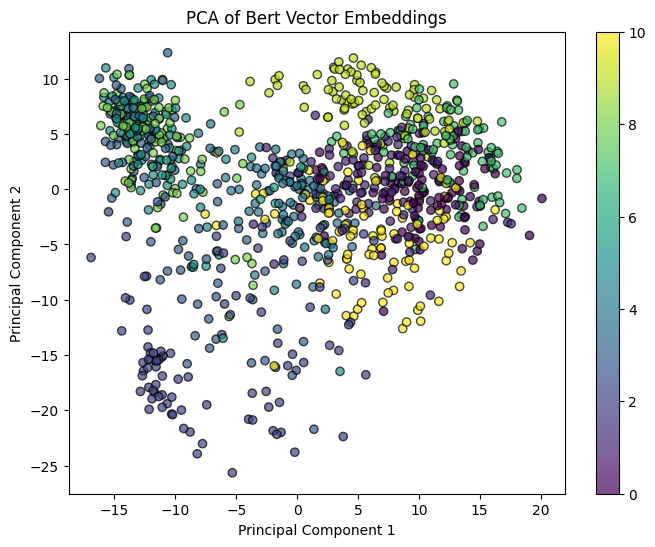

In [60]:
#PCA to see how the groups are clustered, can give us an idea how each method might perform
X = docs_with_embedding_vectors['bert_vector'].tolist()

label_encoder = LabelEncoder()

y = docs_with_embedding_vectors['class']
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title('PCA of Bert Vector Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)
plt.show()

/var/folders/20/m92wkwvs3fn_bgkj66gjn2fw0000gn/T/ipykernel_88705/3562666652.py:15: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 3 Axes> than <Figure size 1000x800 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter, label='Classes')


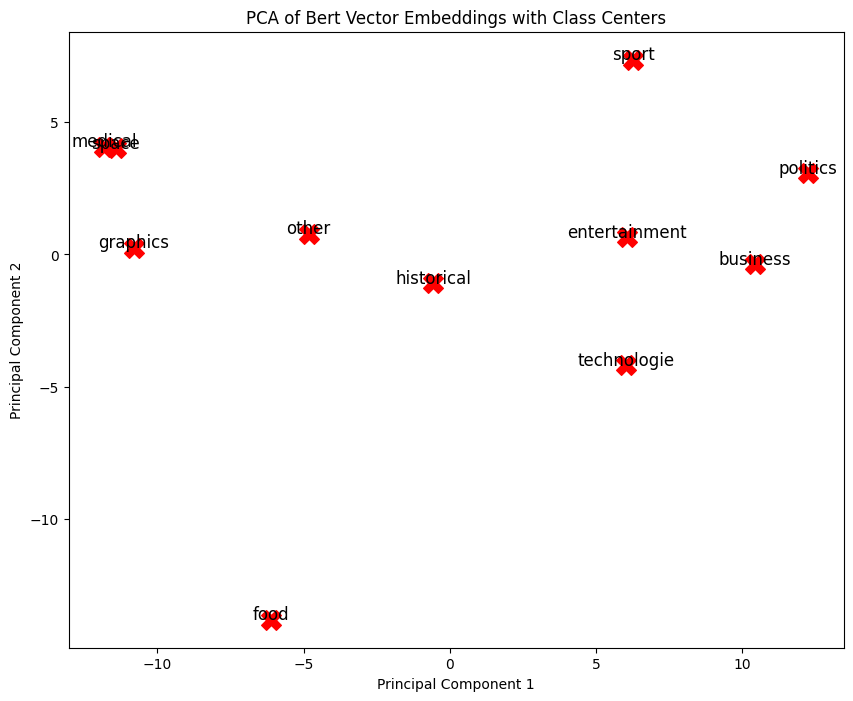

In [61]:

unique_classes = np.unique(y_encoded)
class_centers = np.array([X_pca[y_encoded == cls].mean(axis=0) for cls in unique_classes])
plt.figure(figsize=(10, 8))

# Plotting class centers
for i, center in enumerate(class_centers):
    plt.scatter(center[0], center[1], c='red', s=200, marker='X')  # 'X' marker for centers
    plt.text(center[0], center[1], label_encoder.inverse_transform([unique_classes[i]])[0], 
             color='black', fontsize=12, ha='center')

# Adding features to the plot
plt.title('PCA of Bert Vector Embeddings with Class Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Classes')
plt.show()

In [ ]:
#Medical and Space categories are very similar to each other. 

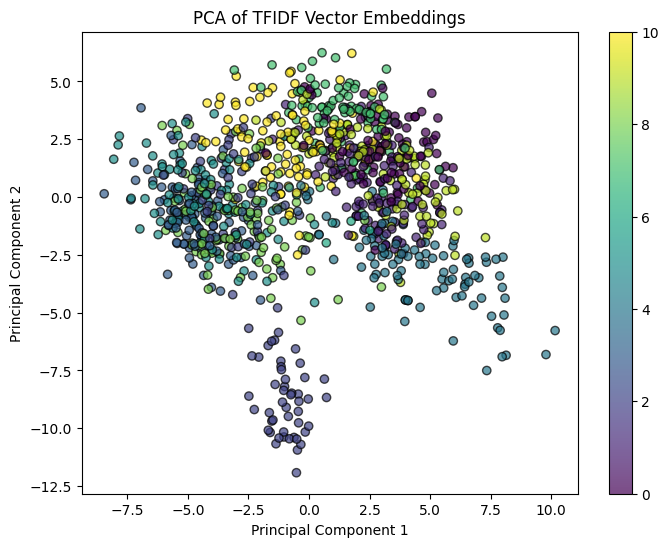

In [59]:
#PCA to see how the groups are clustered, can give us an idea how each method might perform
X = docs_with_embedding_vectors['tfidf_vector'].tolist()

label_encoder = LabelEncoder()

y = docs_with_embedding_vectors['class']
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_encoded, cmap='viridis', edgecolor='k', alpha=0.7)
plt.title('PCA of TFIDF Vector Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter)
plt.show()

/var/folders/20/m92wkwvs3fn_bgkj66gjn2fw0000gn/T/ipykernel_88705/2502904761.py:15: UserWarning: Adding colorbar to a different Figure <Figure size 800x600 with 4 Axes> than <Figure size 1000x800 with 1 Axes> which fig.colorbar is called on.
  plt.colorbar(scatter, label='Classes')


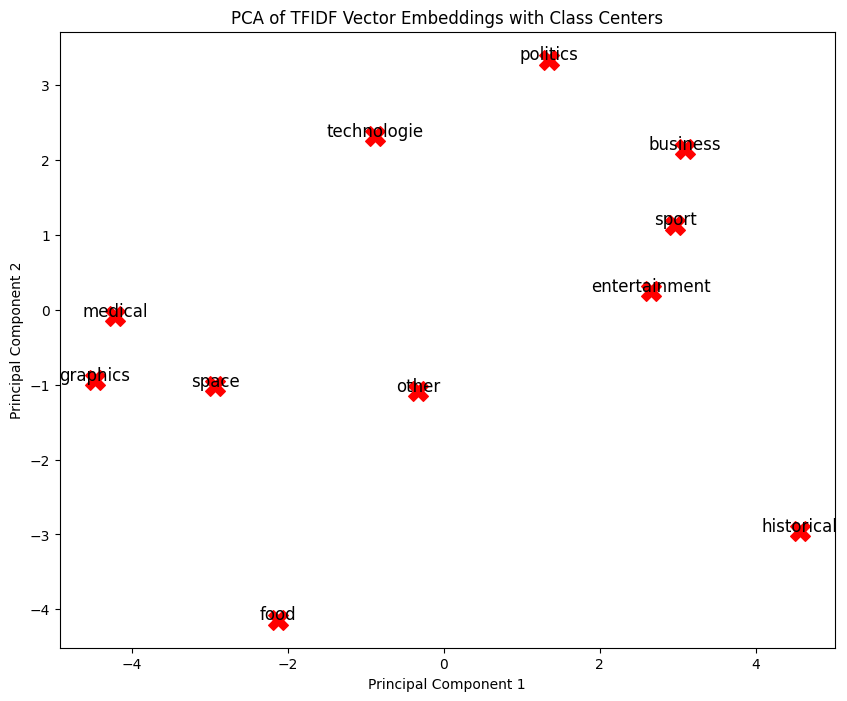

In [58]:
unique_classes = np.unique(y_encoded)
class_centers = np.array([X_pca[y_encoded == cls].mean(axis=0) for cls in unique_classes])
plt.figure(figsize=(10, 8))

# Plotting class centers
for i, center in enumerate(class_centers):
    plt.scatter(center[0], center[1], c='red', s=200, marker='X')  # 'X' marker for centers
    plt.text(center[0], center[1], label_encoder.inverse_transform([unique_classes[i]])[0], 
             color='black', fontsize=12, ha='center')

# Adding features to the plot
plt.title('PCA of TFIDF Vector Embeddings with Class Centers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Classes')
plt.show()

In [ ]:
#it seems like tfidf vectorization does a better job of separating the space and medical class centers. Would
#be interested in evaluating both approaches.

In [297]:
def pickle_labels(labels):
    label_encoder = LabelEncoder()
    label_encoder.fit(labels)

    # Now save the fitted LabelEncoder to a file
    with open('/Users/alex/trellis-document-classification/data/doc_label_encoding.pkl', 'wb') as file:
        pickle.dump(label_encoder, file)


def get_pickled_labels():
    with open('/Users/alex/trellis-document-classification/data/doc_label_encoding.pkl', 'rb') as file:
        loaded_label_encoder = pickle.load(file)
    return loaded_label_encoder

#splitting data into train, validation and test
#with the other class going into the test group.
#i am going to use the validation group to set hyperparameters of distance
#that will help us classify the other category in the test group
#
#pickling labels to help with models that dont return classes out of the box
def split_data(df):
    other_data = df[df['class'] == 'other']
    non_other_data = df[df['class'] != 'other']
    pickle_labels(non_other_data['class'])

    # Create a dictionary to store class mappings
    train_data, temp_remaining_data = train_test_split(non_other_data, test_size=0.4, stratify=non_other_data['class'], random_state=42)
    remaining_data = pd.concat([temp_remaining_data, other_data])
    validation_data, test_data = train_test_split(remaining_data, test_size=0.5, stratify=remaining_data['class'], random_state=42)

    return train_data, validation_data, test_data

In [333]:
train_data, validation_data, test_data = split_data(docs_with_embedding_vectors)
train_data.to_csv('/Users/alex/trellis-document-classification/data/train/train_data.csv')
validation_data.to_csv('/Users/alex/trellis-document-classification/data/validation/validation_data.csv')
test_data.to_csv('/Users/alex/trellis-document-classification/data/test/test_data.csv')

In [128]:
pickled_labels = get_pickled_labels()

In [129]:
pickled_labels.transform(['business'])

array([0])

In [130]:
pickled_labels.inverse_transform([0, 1, 2])

array(['business', 'entertainment', 'food'], dtype=object)

In [152]:
#Trying basic logistic regression to start
from sklearn.linear_model import LogisticRegression

log_tfidf_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')  # 'multinomial' for multi-class
log_tfidf_model.fit(train_data['tfidf_vector'].tolist(), train_data['class'].tolist())

log_bert_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
log_bert_model.fit(train_data['bert_vector'].tolist(), train_data['class'].tolist())


/Users/alex/Library/Caches/pypoetry/virtualenvs/trellis-document-classification-ZLN-tGqV-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/alex/Library/Caches/pypoetry/virtualenvs/trellis-document-classification-ZLN-tGqV-py3.9/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='multinomial')

In [338]:
#Trying to find a threshold with the validation dataset to help me identify the "other" documents.

def calculate_entropies(probabilities):
    return np.array([entropy(prob) for prob in probabilities])

def predict_with_probs(model, X, pickled_labels):
    probabilities = model.predict_proba(X)
    
    predictions = []
    
    for prob in probabilities:
        max_prob = np.max(prob)
        predictions.append(pickled_labels.inverse_transform([np.argmax(prob)])[0])

    return predictions, probabilities

val_tfidf_preds, val_tfidf_probs = predict_with_probs(log_tfidf_model, validation_data['tfidf_vector'].tolist(), pickled_labels)
val_bert_preds, val_bert_probs = predict_with_probs(log_bert_model, validation_data['bert_vector'].tolist(), pickled_labels)

def evaluate_prob_thresholds(probs, y_true, thresholds):
    f1_scores = []
    accuracies = []
    other_counts = []
    other_f1_scores = []
    other_f1_accuracies = []
    for threshold in thresholds:
        # Apply the threshold to the max probability of each prediction
        preds = [pickled_labels.inverse_transform([np.argmax(prob)])[0] if np.max(prob) >= threshold else 'other' for prob in probs]

        counter = list(zip(preds, y_true.tolist()))

        correct_other_count = len([pred[0] for pred in counter if counter[1] == 'other'])

        f1 = f1_score(y_true, preds, average='macro')
        acc = accuracy_score(y_true, preds)
        
        f1_scores.append(f1)
        accuracies.append(acc)
        other_counts.append(correct_other_count)
    return thresholds, f1_scores, accuracies, other_counts

def evaluate_entropy_thresholds(probs, y_true, thresholds):
    f1_scores = []
    accuracies = []
    other_counts = []
    other_f1_scores = []
    other_f1_accuracies = []

    entropies = calculate_entropies(probs)

    for threshold in thresholds:
        # Apply the threshold to the max probability of each prediction
        prob_entropies = list(zip(probs, entropies, y_true))
        preds = [pickled_labels.inverse_transform([np.argmax(prob_ent[0])])[0] if prob_ent[1] >= threshold else 'other' for prob_ent in prob_entropies]

        f1 = f1_score(y_true, preds, average='weighted')
        acc = accuracy_score(y_true, preds)
        
        counter = list(zip(preds, y_true.tolist()))

        correct_other_count = len([pred[0] for pred in counter if counter[1] == 'other'])

        
        f1_scores.append(f1)
        accuracies.append(acc)
        other_counts.append(correct_other_count)
    return thresholds, f1_scores, accuracies, other_counts

prob_thresholds = np.linspace(0.1, 0.9, 100)  # Example threshold values
entropy_thresholds = np.linspace(0.1, 0.9, 100)

tf_prob_thresholds, tf_prob_f1_scores, tf_prob_accuracies, tf_prob_other_counts = evaluate_prob_thresholds(val_tfidf_probs, validation_data['class'], prob_thresholds)
tf_entropy_thresholds, tf_entropy_f1_scores, tf_entropy_accuracies, tf_ent_other_counts = evaluate_entropy_thresholds(val_tfidf_probs, validation_data['class'], entropy_thresholds)

bert_prob_thresholds, bert_prob_f1_scores, bert_prob_accuracies, bert_prob_other_counts = evaluate_prob_thresholds(val_bert_probs, validation_data['class'], prob_thresholds)
bert_entropy_thresholds, bert_entropy_f1_scores, bert_entropy_accuracies, bert_ent_other_counts = evaluate_entropy_thresholds(val_bert_probs, validation_data['class'], entropy_thresholds)



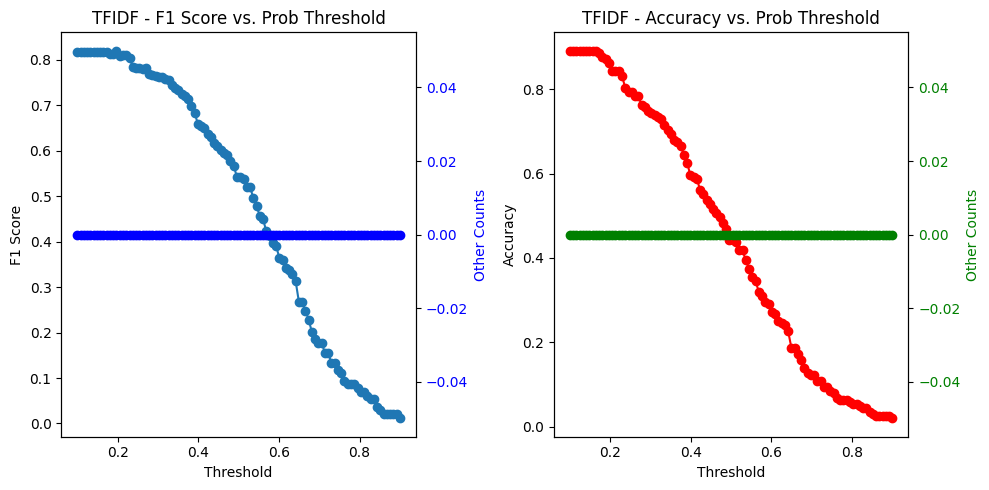

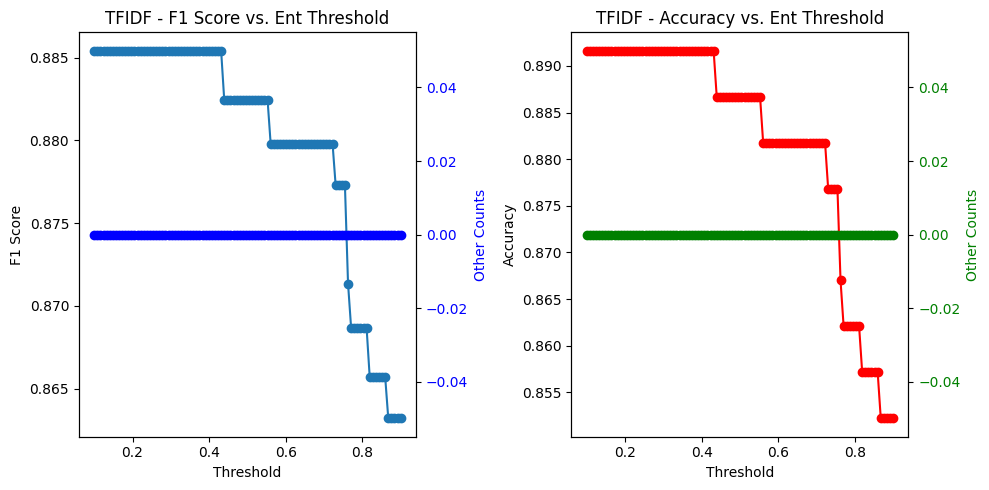

In [339]:
import matplotlib.pyplot as plt

# First set of plots
plt.figure(figsize=(10, 5))

# F1 Score plot with secondary axis
plt.subplot(1, 2, 1)
ax1 = plt.gca()  # Get the current axis
ax1.plot(tf_prob_thresholds, tf_prob_f1_scores, marker='o')
ax1.set_title('TFIDF - F1 Score vs. Prob Threshold')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('F1 Score')
ax2 = ax1.twinx()  # Create a second y-axis
ax2.plot(tf_prob_thresholds, tf_prob_other_counts, marker='o', color='blue', linestyle='--')
ax2.set_ylabel('Other Counts', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Accuracy plot with secondary axis
plt.subplot(1, 2, 2)
ax3 = plt.gca()
ax3.plot(tf_prob_thresholds, tf_prob_accuracies, marker='o', color='red')
ax3.set_title('TFIDF - Accuracy vs. Prob Threshold')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Accuracy')
ax4 = ax3.twinx()
ax4.plot(tf_prob_thresholds, tf_prob_other_counts, marker='o', color='green', linestyle='--')
ax4.set_ylabel('Other Counts', color='green')
ax4.tick_params(axis='y', labelcolor='green')

plt.tight_layout()
plt.show()

# Second set of plots
plt.figure(figsize=(10, 5))

# F1 Score plot with secondary axis
plt.subplot(1, 2, 1)
ax5 = plt.gca()
ax5.plot(tf_entropy_thresholds, tf_entropy_f1_scores, marker='o')
ax5.set_title('TFIDF - F1 Score vs. Ent Threshold')
ax5.set_xlabel('Threshold')
ax5.set_ylabel('F1 Score')
ax6 = ax5.twinx()
ax6.plot(tf_entropy_thresholds, tf_ent_other_counts, marker='o', color='blue', linestyle='--')
ax6.set_ylabel('Other Counts', color='blue')
ax6.tick_params(axis='y', labelcolor='blue')

# Accuracy plot with secondary axis
plt.subplot(1, 2, 2)
ax7 = plt.gca()
ax7.plot(tf_entropy_thresholds, tf_entropy_accuracies, marker='o', color='red')
ax7.set_title('TFIDF - Accuracy vs. Ent Threshold')
ax7.set_xlabel('Threshold')
ax7.set_ylabel('Accuracy')
ax8 = ax7.twinx()
ax8.plot(tf_entropy_thresholds, tf_ent_other_counts, marker='o', color='green', linestyle='--')
ax8.set_ylabel('Other Counts', color='green')
ax8.tick_params(axis='y', labelcolor='green')

plt.tight_layout()
plt.show()

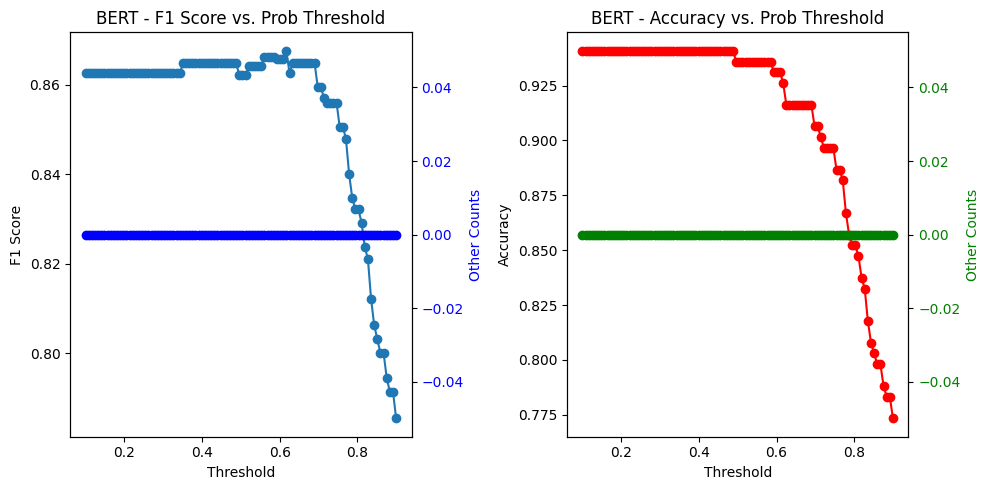

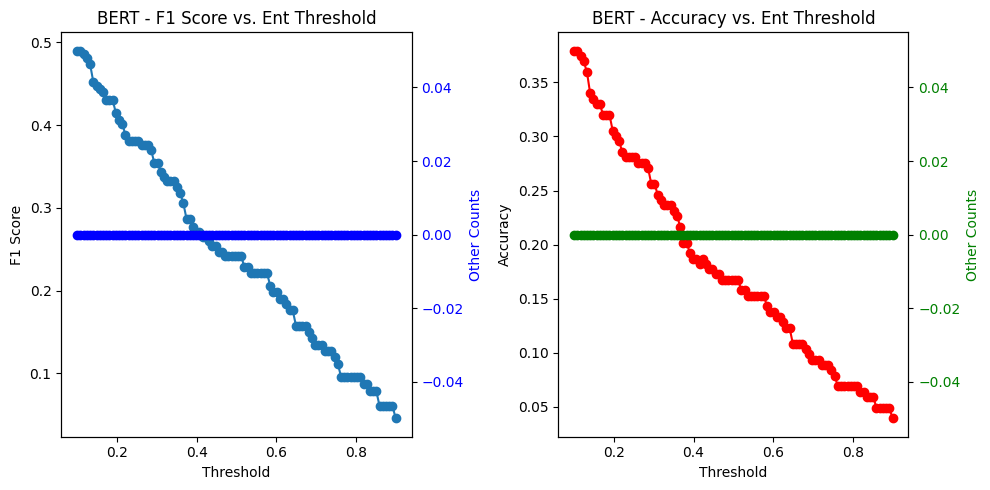

In [340]:
plt.figure(figsize=(10, 5))

# F1 Score plot with secondary axis for Probability Thresholds
plt.subplot(1, 2, 1)
ax1 = plt.gca()  # Get the current axis
ax1.plot(bert_prob_thresholds, bert_prob_f1_scores, marker='o')
ax1.set_title('BERT - F1 Score vs. Prob Threshold')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('F1 Score')
ax2 = ax1.twinx()  # Create a second y-axis
ax2.plot(bert_prob_thresholds, bert_prob_other_counts, marker='o', color='blue', linestyle='--')
ax2.set_ylabel('Other Counts', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Accuracy plot with secondary axis for Probability Thresholds
plt.subplot(1, 2, 2)
ax3 = plt.gca()
ax3.plot(bert_prob_thresholds, bert_prob_accuracies, marker='o', color='red')
ax3.set_title('BERT - Accuracy vs. Prob Threshold')
ax3.set_xlabel('Threshold')
ax3.set_ylabel('Accuracy')
ax4 = ax3.twinx()
ax4.plot(bert_prob_thresholds, bert_prob_other_counts, marker='o', color='green', linestyle='--')
ax4.set_ylabel('Other Counts', color='green')
ax4.tick_params(axis='y', labelcolor='green')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))

# F1 Score plot with secondary axis for Entropy Thresholds
plt.subplot(1, 2, 1)
ax5 = plt.gca()
ax5.plot(bert_entropy_thresholds, bert_entropy_f1_scores, marker='o')
ax5.set_title('BERT - F1 Score vs. Ent Threshold')
ax5.set_xlabel('Threshold')
ax5.set_ylabel('F1 Score')
ax6 = ax5.twinx()
ax6.plot(bert_entropy_thresholds, bert_ent_other_counts, marker='o', color='blue', linestyle='--')
ax6.set_ylabel('Other Counts', color='blue')
ax6.tick_params(axis='y', labelcolor='blue')

# Accuracy plot with secondary axis for Entropy Thresholds
plt.subplot(1, 2, 2)
ax7 = plt.gca()
ax7.plot(bert_entropy_thresholds, bert_entropy_accuracies, marker='o', color='red')
ax7.set_title('BERT - Accuracy vs. Ent Threshold')
ax7.set_xlabel('Threshold')
ax7.set_ylabel('Accuracy')
ax8 = ax7.twinx()
ax8.plot(bert_entropy_thresholds, bert_ent_other_counts, marker='o', color='green', linestyle='--')
ax8.set_ylabel('Other Counts', color='green')
ax8.tick_params(axis='y', labelcolor='green')

plt.tight_layout()
plt.show()

In [341]:
#Wasnt able to find any of the other documents, but it looks like a max threshold of ~0.6 is suitable for classifying the data the best.
def predict_test_with_probs_threshold(model, X, pickled_labels, threshold = 0.6):
    probabilities = model.predict_proba(X)
    
    predictions = []
    
    for prob in probabilities:
        max_prob = np.max(prob)
        if max_prob > threshold:
            predictions.append(pickled_labels.inverse_transform([np.argmax(prob)])[0])
        else:
            predictions.append('other')

    return predictions, probabilities

test_preds, test_probs = predict_test_with_probs_threshold(log_bert_model, test_data['bert_vector'].tolist(), pickled_labels)

print(classification_report(test_data['class'], test_preds))

               precision    recall  f1-score   support

     business       1.00      0.80      0.89        20
entertainment       0.95      1.00      0.98        20
         food       0.95      1.00      0.98        20
     graphics       0.95      1.00      0.98        20
   historical       0.95      0.95      0.95        20
      medical       0.95      0.95      0.95        20
        other       0.18      0.67      0.29         3
     politics       0.95      1.00      0.98        20
        space       1.00      0.80      0.89        20
        sport       1.00      1.00      1.00        20
  technologie       1.00      0.80      0.89        20

     accuracy                           0.93       203
    macro avg       0.90      0.91      0.89       203
 weighted avg       0.96      0.93      0.94       203



In [374]:
#BERT embeddings with logistic model and probability threshold of .6 seems to work the best. We even managed to capture some of the other
#category with this model. This is the base that I will build the service around.

def get_bert_embeddings(data):
    from transformers import AutoTokenizer, TFAutoModel
    tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
    model = TFAutoModel.from_pretrained('bert-base-uncased')
    inputs = tokenizer(text, return_tensors='tf', truncation=True, padding='max_length', max_length=512)
    outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].numpy()

model_bundle = {
        'label_encoder': label_encoder,
        'fit_model': log_bert_model,
        'prob_threshold': 0.6
}


dump(model_bundle, '/Users/alex/trellis-document-classification/trellis_document_classification/service_model_bundle.joblib')


['/Users/alex/trellis-document-classification/trellis_document_classification/service_model_bundle.joblib']

In [342]:
#APPENDIX
#I also tried to do KNN with a faiss index db. It doesn't actually perform as well as the logistic regressions above, but wanted to show my work.
import faiss

from collections import Counter

def load_into_faiss(df, type_vector):

    vectors = np.vstack(df[type_vector].values).astype('float32')
    ids = np.array(df.index).astype('int64')

    dimension = vectors.shape[1]

    index = faiss.IndexFlatL2(dimension)
    
    index_with_ids = faiss.IndexIDMap(index)

    index_with_ids.add_with_ids(vectors, ids)

    return index_with_ids

In [343]:
bert_train_faiss_index = load_into_faiss(train_data, 'bert_vector')
tfidf_train_faiss_index = load_into_faiss(train_data, 'tfidf_vector')

In [344]:
def find_similar_documents(search_vectors, faiss_index, k):
    search_vectors = np.vstack(search_vectors.values).astype('float32')
    distances, indices = faiss_index.search(search_vectors, k)
    return distances, indices

def map_indices_to_class(indices_list_of_lists, train_df):
    preds = []
    for index_list in indices_list_of_lists:
        nearest_labels = train_df.loc[train_df.index.isin([ix for ix in index_list])]['class']
        class_counts = Counter(nearest_labels)
        pred_class = class_counts.most_common(1)[0][0]
        preds.append(pred_class)
    return preds


In [345]:
def predict_knn_labels(search_vectors, index, train_data, k):
    distances, indices = find_similar_documents(search_vectors, index, k=k)
    pred_classes = map_indices_to_class(indices, train_data)
    return pred_classes

In [346]:
val_knn_preds_bert = predict_knn_labels(validation_data['bert_vector'], bert_train_faiss_index, train_data, k=10)
val_knn_preds_tfidf = predict_knn_labels(validation_data['tfidf_vector'], tfidf_train_faiss_index, train_data, k=10)

In [347]:
report = classification_report(validation_data['class'], val_knn_preds_bert)
print(report)

               precision    recall  f1-score   support

     business       0.83      0.95      0.88        20
entertainment       1.00      0.85      0.92        20
         food       1.00      1.00      1.00        20
     graphics       0.67      0.70      0.68        20
   historical       0.95      0.95      0.95        20
      medical       0.62      1.00      0.77        20
        other       0.00      0.00      0.00         3
     politics       0.91      1.00      0.95        20
        space       1.00      0.55      0.71        20
        sport       1.00      1.00      1.00        20
  technologie       0.94      0.80      0.86        20

     accuracy                           0.87       203
    macro avg       0.81      0.80      0.79       203
 weighted avg       0.88      0.87      0.86       203



/Users/alex/Library/Caches/pypoetry/virtualenvs/trellis-document-classification-ZLN-tGqV-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/Library/Caches/pypoetry/virtualenvs/trellis-document-classification-ZLN-tGqV-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/Library/Caches/pypoetry/virtualenvs/trellis-document-classification-ZLN-tGqV-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is

In [348]:
report = classification_report(validation_data['class'], val_knn_preds_tfidf)
print(report)

               precision    recall  f1-score   support

     business       0.82      0.70      0.76        20
entertainment       0.92      0.60      0.73        20
         food       1.00      0.70      0.82        20
     graphics       0.88      0.70      0.78        20
   historical       0.45      1.00      0.62        20
      medical       0.55      0.85      0.67        20
        other       0.00      0.00      0.00         3
     politics       0.74      0.85      0.79        20
        space       0.91      0.50      0.65        20
        sport       0.95      1.00      0.98        20
  technologie       0.92      0.60      0.73        20

     accuracy                           0.74       203
    macro avg       0.74      0.68      0.68       203
 weighted avg       0.80      0.74      0.74       203



/Users/alex/Library/Caches/pypoetry/virtualenvs/trellis-document-classification-ZLN-tGqV-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/Library/Caches/pypoetry/virtualenvs/trellis-document-classification-ZLN-tGqV-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/Library/Caches/pypoetry/virtualenvs/trellis-document-classification-ZLN-tGqV-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is

In [349]:
def evaluate_knn_k_thresholds(y_true, ks):
    f1_scores = []
    accuracies = []
    other_counts = []
    other_f1_scores = []
    other_f1_accuracies = []
    for k in ks:
        # Apply the threshold to the max probability of each prediction
        preds = predict_knn_labels(validation_data['bert_vector'], bert_train_faiss_index, train_data, k=k)

        counter = list(zip(preds, y_true.tolist()))

        correct_other_count = len([pred[0] for pred in counter if counter[1] == 'other'])

        f1 = f1_score(y_true, preds, average='weighted')
        acc = accuracy_score(y_true, preds)
        
        f1_scores.append(f1)
        accuracies.append(acc)
        other_counts.append(correct_other_count)
    return ks, f1_scores, accuracies, other_counts

k_thresholds = [x + 1 for x in range(30)]

k_thresholds, f1_scores, accuracies, other_counts = evaluate_knn_k_thresholds(validation_data['class'], k_thresholds)

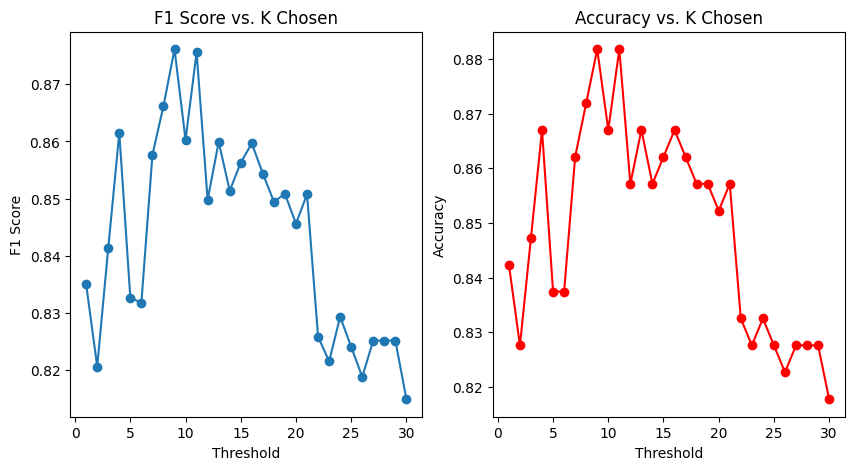

In [350]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(k_thresholds, f1_scores, marker='o')
plt.title('F1 Score vs. K Chosen')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')

plt.subplot(1, 2, 2)
plt.plot(k_thresholds, accuracies, marker='o', color='red')
plt.title('Accuracy vs. K Chosen')
plt.xlabel('Threshold')
plt.ylabel('Accuracy')

plt.show()

In [322]:
test_knn_preds_bert = predict_knn_labels(test_data['bert_vector'], bert_train_faiss_index, train_data, k=9)
report = classification_report(test_data['class'], test_knn_preds_bert)
print(report)

               precision    recall  f1-score   support

     business       0.89      0.80      0.84        20
entertainment       0.95      0.95      0.95        20
         food       0.91      1.00      0.95        20
     graphics       0.82      0.90      0.86        20
   historical       0.95      0.90      0.92        20
      medical       0.66      0.95      0.78        20
        other       0.00      0.00      0.00         3
     politics       0.86      0.95      0.90        20
        space       0.83      0.50      0.62        20
        sport       1.00      1.00      1.00        20
  technologie       0.95      0.90      0.92        20

     accuracy                           0.87       203
    macro avg       0.80      0.80      0.80       203
 weighted avg       0.87      0.87      0.86       203



/Users/alex/Library/Caches/pypoetry/virtualenvs/trellis-document-classification-ZLN-tGqV-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/Library/Caches/pypoetry/virtualenvs/trellis-document-classification-ZLN-tGqV-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/alex/Library/Caches/pypoetry/virtualenvs/trellis-document-classification-ZLN-tGqV-py3.9/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is

In [ ]:
#These models look more unstable (sensitive to k), and dont perform as well. so I am going to go with the above for the service.